# Speech frequency analysis for CS:GO matches

In this experiment, we took an audio sample from one of the CS:GO matches and we tried to compute its speech frequency (i.e.: the rate at which words are "spoken" throughout the whole audio) by using the google NLP API.
More specifically, we extracted one small audio clip (approximately 1 min long) from one of the highlights detected by the RMS method. 

## Libraries import

In [1]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
import speech_recognition as sr
import wave
import librosa

/opt/anaconda3/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Functions definition

To make the code more clear, we define a function using the Google API to retrieve the text.

In [2]:
def retrieve_text(audio_path):
    
    # Initialize recognizer class (for recognizing the speech)
    r = sr.Recognizer()

    # Reading Audio file as source
    # listening the audio file and store in audio_text variable

    with sr.AudioFile(audio_path) as source:

        audio_text = r.listen(source)

    # recoginize_() method will throw a request error if the API is unreachable, hence using exception handling
        try:

            # using google speech recognition
            print('Converting audio transcripts into text ...')
            text = r.recognize_google(audio_text)
            print(text)

        except:
             print('Sorry.. run again...')
    

## Speech recognition: first try

On this first try we tried to extract the audio from the file, without any preprocessing.

In [3]:
retrieve_text('experiments_data/trimmed_audio.wav')

Converting audio transcripts into text ...
another shot from all of this actually likes on the back that's enough for him to get traded back in return it raining again like that when he's got the M4 in Dead or Alive and it's just down to Stewie as well


By listening to the audio track used, it can be observed how the speech recognition tool has not captured the whole speech and is not able to understand a lot of words used.
The main explaination for this result is that, even if the language is English, the people speaking are using players names and terms from the "gaming dialect", which is probably too specific for the Google API to be understood.
Moreover, being a very important moment of the game, for most of the time the commentators speak faster than usual and it's therefore harder for the algorithm to catch every word. Also their voices overlap in many points and the crowd cheering in the background does not help as well.

## Preprocessing - part 1: slowing the audio down

In order to reduce the impact of the fast speech, we decided to slow down the selected audio to enable the algorithm to have a better understading of the words in it. Of course, the reduction must not be too high otherwise the words will be even more unrecognizable and the result will be of much lower quality: thus, we opted for a 7% reduction of the audio speed.

In [4]:
multiplier = 0.94

import shutil
shutil.copy2('./experiments_data/trimmed_audio.wav', 'experiments_data/slow_audio.wav')

spf = wave.open('./experiments_data/slow_audio.wav', 'rb')
fr=spf.getframerate() # frame rate
channels = spf.getnchannels()
swidth = spf.getsampwidth()
signal = spf.readframes(-1)

wf = wave.open('./experiments_data/slow_audio.wav', 'wb')
wf.setnchannels(channels)
wf.setsampwidth(swidth)
wf.setframerate(fr*multiplier)
wf.writeframes(signal)
wf.close()

We then tried to use the Google API again, on the slower speed audio.

In [5]:
retrieve_text('./experiments_data/slow_audio.wav')

Converting audio transcripts into text ...
another shot from all of this time actually legs or back that's enough for him to get traded back in again on the M4 in Dead or Alive and it's down to Stewie as well


It can be easily observed that the result has not changed too much from the previous one and the overall quality remains quite poor.

## Preprocessing - part 2: filtering noise out

To reduce the impact of the background noise, we tried to filter it out.

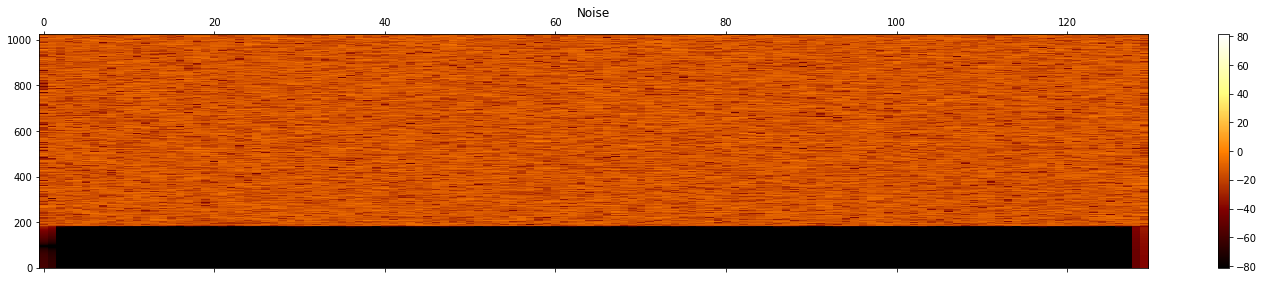

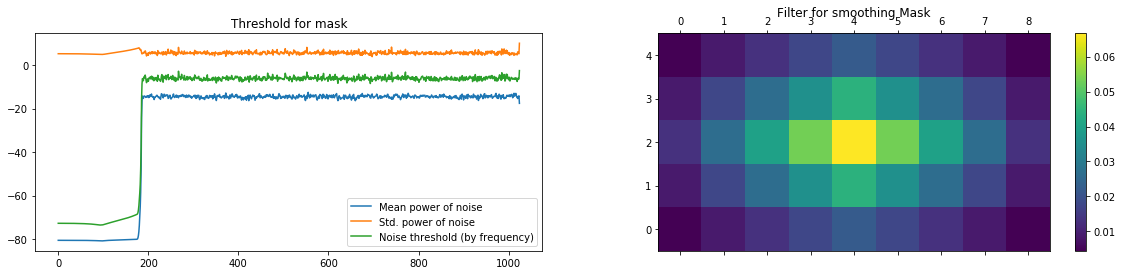

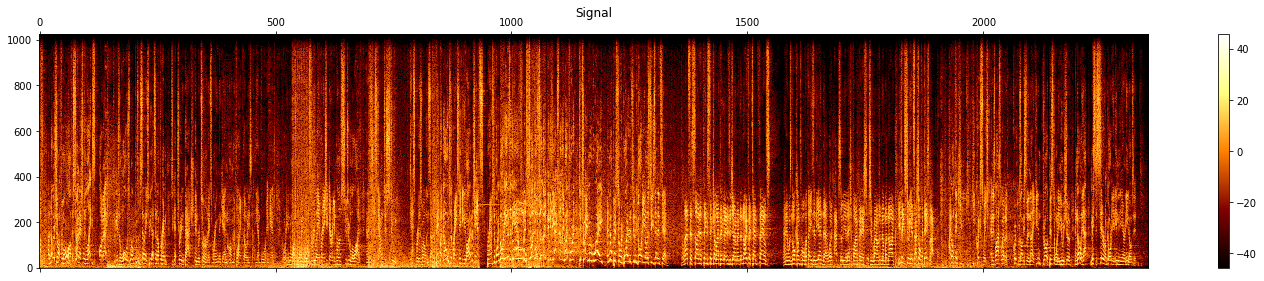

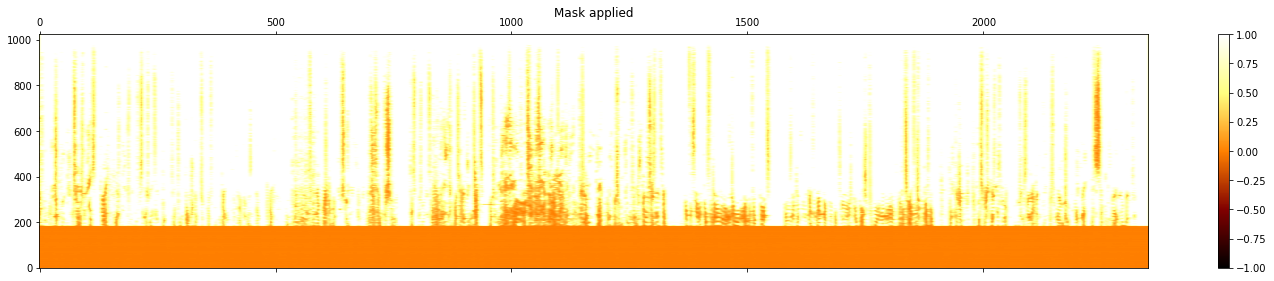

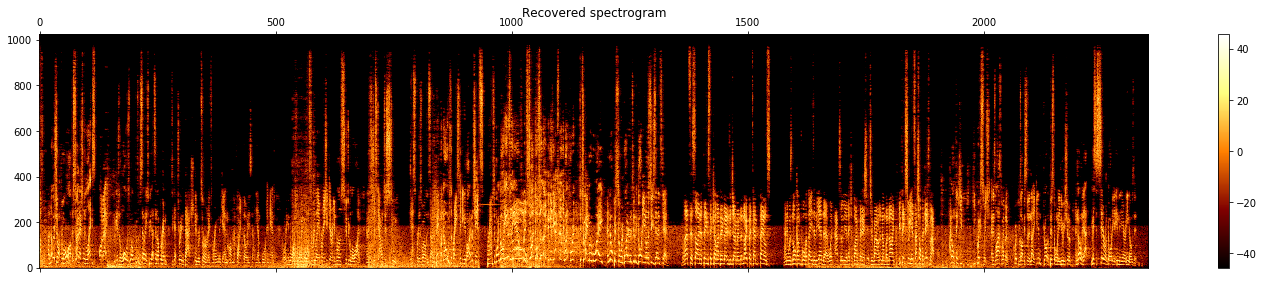

In [8]:
from math import floor
myaudio_data, audio_rate = librosa.load('./experiments_data/trimmed_audio.wav')

sample_data = myaudio_data

noise_len = 3 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(sample_data), samplerate=audio_rate)*10
noise_clip = noise[:audio_rate*noise_len]

audio_clip_band_limited = sample_data+noise

noise_reduced = nr.reduce_noise(audio_clip=sample_data, noise_clip=noise_clip, prop_decrease=1.0, verbose=True)

sf.write('./experiments_data/no_noise.wav', noise_reduced, audio_rate)

In [9]:
# Note: if this doesn't work, it probably means that something went wrong in the previous step (filtering noise out)
#       run that part again and it should work, we have not been able to understand what goes wrong in the process

retrieve_text('./experiments_data/no_noise.wav')

Converting audio transcripts into text ...
and it's just down to Stewie


By listening to the audio, it seems like filtering out the signal noise this way is adding some echo and is therefore harder for the algorithm to capture the single words.